## A/B Test Results Analysis

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I'll be working to get the results of an A/B test run by an e-commerce website.  the goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

Reading the dataset and taking a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


number of rows in the dataset.

In [3]:
df.shape[0]

294478

The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

The proportion of users converted.

In [5]:
conv_prop = df[df.converted == 1].shape[0] / df.shape[0]
conv_prop

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.group.unique(), df.landing_page.unique()

(array(['control', 'treatment'], dtype=object),
 array(['old_page', 'new_page'], dtype=object))

In [7]:
treatment_old = df.query("group == 'treatment' and landing_page == 'old_page'")
control_new = df.query("group == 'control' and landing_page == 'new_page'")
frames = [treatment_old, control_new]
new_treatment_x = pd.concat(frames)

new_treatment_x.shape[0]

3893

Checking for missing values

In [8]:
df.isnull().sum().sum()

0

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Storing your new dataframe in **df2**.

In [9]:
control_old = df[(df.landing_page == 'old_page') & (df.group == 'control')]
treatment_new = df[(df.landing_page == 'new_page') & (df.group == 'treatment')]
frames = [control_old, treatment_new]

df2 = pd.concat(frames)

In [10]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Number of unique **user_id**s in **df2**

In [11]:
df2.user_id.nunique()

290584

Checking for duplicated **user_id**

In [12]:
df2.loc[df2.user_id.duplicated(), :]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Row information for the repeat **user_id**

In [13]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**

In [14]:
row_dup = df2[(df2.user_id == 773192) & (df2.timestamp == '2017-01-14 02:55:59.590927')]
df2 = df2.drop(row_dup.index)

The probability of an individual converting regardless of the page they receive

In [15]:
conv_prob = df2[df2.converted == 1].shape[0] / df2.shape[0]
conv_prob

0.11959708724499628

The probability users converted given that an individual was in the `control` group

In [16]:
control_conv_prob = df2[(df2.converted == 1) & (df2.group == 'control')].shape[0] / df2[df2.group == 'control'].shape[0]
control_conv_prob

0.1203863045004612

The probability users converted given that an individual was in the `treatment` group

In [17]:
treat_conv_prob = df2[(df2.converted == 1) & (df2.group == 'treatment')].shape[0] / df2[df2.group == 'treatment'].shape[0]
treat_conv_prob

0.11880806551510564

The probability that an individual received the new page

In [18]:
df2[df2.landing_page == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

In [19]:
obs_diff = treat_conv_prob - control_conv_prob
obs_diff

-0.0015782389853555567

Is there sufficient evidence to say that the new treatment page leads to more converions?

**No as the obs_diff is negative which means that the conversion rate for the control group yields better results than the treatment group**

<a id='ab_test'></a>
### Part II - A/B Test

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% the null and alternative hypotheses should be

**$H_0$** : **$P_{old}$** >= **$P_{new}$**
<br>
  **$H_1$** : **$P_{old}$** < **$P_{new}$**

The **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = p_null = conv_prob
p_new

0.11959708724499628

The **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_null

0.11959708724499628

$n_{new}$

In [22]:
n_treat_new = df2[(df2.group == 'treatment') & (df2.landing_page == 'new_page')].shape[0]
n_treat_new

145310

$n_{old}$

In [23]:
n_treat_old = df2[(df2.group == 'control') & (df2.landing_page == 'old_page')].shape[0]
n_treat_old

145274

Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_treat_new)

Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_null, n_treat_old)

Finding $p_{new}$ - $p_{old}$ for the simulated values

In [26]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00039727169032133247

Simulating 10,000 $p_{new}$ - $p_{old}$ values and storing all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_treat_new, p_new, 10000) / n_treat_new 
old_converted_simulation = np.random.binomial(n_treat_old, p_null, 10000) / n_treat_old 
p_diffs = new_converted_simulation - old_converted_simulation

Plotting a histogram of the **p_diffs**.

Finding the proportion of the **p_diffs** that is greater than the actual difference observed in **ab_data.csv**

In [28]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

In [29]:
p_val = (null_vals > obs_diff).mean()
p_val

0.9041

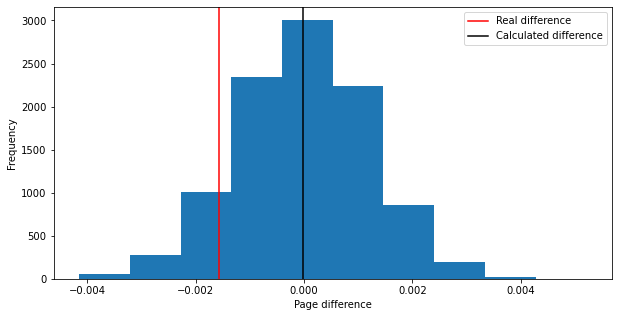

In [30]:
plt.figure(figsize = (10, 5))
plt.hist(p_diffs)
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.axvline(x = obs_diff, color = 'red', label ='Real difference')
plt.axvline(x = p_diffs.mean(), color = 'black', label = 'Calculated difference')
plt.legend();

**The P value which is 90.67% of the population in our simulation is greater than the real difference which makes sense as the probability for a conversion of a new page is lower than that of an old page**

In [31]:
convert_old = len(df2[(df2.landing_page =='old_page')&(df2.converted == 1)])
convert_new = len(df2[(df2.landing_page =='new_page')&(df2.converted == 1)])
convert_old, convert_new

(17489, 17264)

Using `stats.proportions_ztest` to compute the test statistic and p-value.

In [32]:
import statsmodels.api as sm


In [33]:
n_new, n_old = df2.landing_page.value_counts()
zstat, p_value = sm.stats.proportions_ztest(count = [convert_new, convert_old], nobs = [n_new, n_old], alternative = 'larger')
zstat, p_value

(-1.3109241984234394, 0.9050583127590245)

z-score tells us how far the standard deviation is from the mean of the population , the z-score is measured from -3 to 3 and in our case the standard deviation is -1.31**
<br>
**The p-value is 90.5% and it's so different whaich agrees with the previos result and is the error percentage when supporting the alternative hypothesis so in our case with alpha equal to 5% we fail to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result that was acheived in the previous A/B test can also be acheived by performing regression.<br><br>

We will be performing **Logistic Regression** since each row is either a conversion or no conversion.

The goal is to use **statsmodels** to fit the regression model that was specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [34]:
df2['intercept'] = 1
df2['ab_page'] = (df.group == 'treatment').astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


In [35]:
df2.ab_page.value_counts()

1    145310
0    145274
Name: ab_page, dtype: int64

Using **statsmodels** to import your regression model.  Instantiate the model, and fit the model.

In [36]:
log_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The summary of the model

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:               8.077e-06
Time:                        16:00:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**p-value is equal to 0.19 which is the different than what was calculated in part II (0.905) 
the p-value results are different as a different model is used, the p-value in the case of the logit model is 0.19 which is better than that of the z-test but is still insignificant so we fail to reject the null hypothesis**

Should we add additional features to this model

**Additional terms will always improve the model whether the new term adds significant value to the model or not,
Yet some disadvantages might be that adding more and more variables makes it more likely that you will overfit your model to the training data. This can cause the model to try and force the model to fit based on the training data that but will not perform well as it follows a certain forced trend only designed for the training data**

Does it appear that country has an impact on conversion?

In [38]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')

In [39]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [41]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [42]:
log_mod = sm.Logit(df_new.converted, df_new[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:               1.521e-05
Time:                        16:00:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**The countries do have an effect on the conversion rate but not enough to be statistically significant**

In [43]:
df_new['ca_page'] = df_new.ab_page * df_new.CA
df_new['uk_page'] = df_new.ab_page * df_new.UK
df_new['us_page'] = df_new.ab_page * df_new.US

log_mod = sm.Logit(df_new.converted, df_new[['intercept','ab_page','UK','US' ,'uk_page', 'us_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:               3.482e-05
Time:                        16:00:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**The results with the p-values are still not statistically significant**

<a id='conclusions'></a>
## Conclusions

We can conclude that the performance of the original website is actually doing better in terms of conversion rate, based on only the data provided we can conclude that it's better to stick to the original website, However, the data might be misleading as other important factors weren't provided such as amount payed by each customer which for example (if the converted clients that were on the new page payed more on average than the converted clients on the old page) if the new page for example is targeting bigger purchases than the old page that would make for a better comparison, the quantity of the data was sufficient that we could make a fair assessment but the problem was the quality of the resultant as they might've not been the best dependant variable for the best judgement
 

